In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from numpy.random import randint
import seaborn as sns

In [5]:
df_full = pd.read_csv('gene_expression_unique.csv', index_col = 0)

In [6]:
df_full.head()

,11715100_at,11715101_s_at,11715102_x_at,11715103_x_at,11715104_s_at,11715105_at,11715106_x_at,11715107_s_at,11715108_x_at,11715109_at,...,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,Final_DX
7,2.420,2.608,1.790,3.646,2.276,2.089,2.600,4.691,2.361,2.746,...,NaN,NaN,NaN,NaN,5.10609,61.1475,60,60,2017-10-06 23:19:46.0,0
14,2.178,2.347,2.095,3.926,2.170,2.094,2.553,5.084,2.143,3.047,...,2.62162,1.06129,NaN,1.551950,0.00000,0.0000,0,0,2017-10-06 23:19:54.0,2
22,2.336,2.382,1.971,3.768,2.189,2.161,2.458,4.848,2.191,3.138,...,1.02564,1.29731,NaN,0.964352,0.00000,0.0000,0,0,2017-10-06 23:19:55.0,0
27,2.307,2.500,1.998,3.789,2.108,2.070,2.154,4.800,2.649,2.708,...,1.00000,1.30802,NaN,1.044580,0.00000,0.0000,0,0,2017-10-06 23:19:55.0,1
35,2.032,2.179,1.787,3.229,2.204,2.236,2.419,4.200,2.401,2.570,...,1.05128,1.44608,NaN,1.496110,0.00000,0.0000,0,0,2017-10-06 23:19:55.0,0


In [7]:
df_full[df_full['DX'].isnull() == True].index

Int64Index([232, 537, 825, 1394, 1684, 1691, 1982, 2226], dtype='int64')

In [8]:
cols = df_full.dtypes
cols.to_csv('columntypes.txt')

In [9]:
X_full = df_full.iloc[:,0:49386]

In [10]:
def for_loop_status(length, index = 0):
    sys.stdout.write('\r%f%%' % ((index/length)*100))
    sys.stdout.flush()
    index += 1
    return(index)

In [11]:
"""
Function
--------
scale_predictor

Inputs
------
df = the dataframe of data
predictor = str containing the name of the column to be scaled

Returns
-------
the df dataframe, with the values
in the column now scaled by the mean and std
of the predictor

"""
def scale_predictor(df, predictor):
    mean = df[predictor].mean() #get mean
    std = df[predictor].std() #get training standard deviation
    df[predictor] = (df[predictor] - mean)/std #scale df set
    return df

In [12]:
# standardize gene expression data
gene_cols = X_full.columns
length = len(gene_cols) - 1
index = 0
for gene in gene_cols:
    df_full = scale_predictor(df_full, gene)
    index = for_loop_status(length, index)

100.000000%

In [13]:
# split into train and test
np.random.seed(9001)
msk = np.random.rand(len(df_full)) < 0.5
df_train = df_full[msk]
df_test = df_full[~msk]

X_train = df_train.iloc[:,0:49386]
X_test = df_test.iloc[:,0:49386]
y_train = df_train['Final_DX']
y_test = df_test['Final_DX']

In [14]:
# compute correlations of Final_DX with all genes
gene_corrs = []
gene_cols = X_full.columns
length = len(gene_cols) - 1
index = 0
for gene in gene_cols:
    gene_corrs.append(X_full[gene].corr(df_full['Final_DX']))
    index = for_loop_status(length, index)

100.000000%

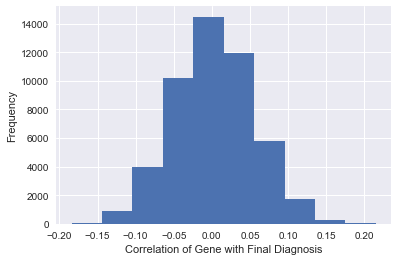

In [15]:
plt.hist(gene_corrs);
plt.xlabel('Correlation of Gene with Final Diagnosis')
plt.ylabel('Frequency')
plt.show()

In [17]:
# store correlation data in dataframe
gene_corr_df = pd.DataFrame()
gene_corr_df['gene'] = gene_cols
gene_corr_df['corr'] = gene_corrs
gene_corr_df = gene_corr_df.sort_values('corr')

In [14]:
# play around with this cell to look at using different predictors

#'''
n = 5
top_neg_corr = gene_corr_df.head(n)
top_pos_corr = gene_corr_df.tail(n)
top_corrs = pd.concat([top_pos_corr, top_neg_corr])
top_genes = top_corrs['gene'].values
top_corrs

'''
cutoff = 0.15
top_neg_corr = gene_corr_df.loc[gene_corr_df['corr'] <= -cutoff]
top_pos_corr = gene_corr_df.loc[gene_corr_df['corr'] >= cutoff]
top_corrs = pd.concat([top_pos_corr, top_neg_corr])
top_genes = top_corrs['gene'].values
len(top_corrs)
'''

"\ncutoff = 0.15\ntop_neg_corr = gene_corr_df.loc[gene_corr_df['corr'] <= -cutoff]\ntop_pos_corr = gene_corr_df.loc[gene_corr_df['corr'] >= cutoff]\ntop_corrs = pd.concat([top_pos_corr, top_neg_corr])\ntop_genes = top_corrs['gene'].values\nlen(top_corrs)\n"

In [15]:
top_corrs
# 2 highly correlated genes are FCRL1 and STMN4, not sure exactly which ones below they are

,gene,corr
10038,11725138_at,0.186508
22894,11737994_a_at,0.188425
3660,11718760_a_at,0.198810
48698,11763798_a_at,0.206025
18413,11733513_a_at,0.215151
6532,11721632_a_at,-0.184159
21780,11736880_x_at,-0.175599
7416,11722516_at,-0.174379
41410,11756510_a_at,-0.173058
31740,11746840_a_at,-0.172506


In [16]:
topcor_mod = {}

topcor_mod['Xtrain'] = X_train[top_genes].values
topcor_mod['Xtest'] = X_test[top_genes].values
topcor_mod['ytrain'] = y_train.values
topcor_mod['ytest'] = y_test.values

In [17]:
# multinomial logistic
topcor_mod['logit_mn'] = LogisticRegressionCV(Cs=7, penalty='l2', random_state = 9001, multi_class='multinomial')
topcor_mod['logit_mn'].fit(topcor_mod['Xtrain'], topcor_mod['ytrain'])

topcor_mod['ypred_train'] = topcor_mod['logit_mn'].predict(topcor_mod['Xtrain'])
topcor_mod['ypred_test'] = topcor_mod['logit_mn'].predict(topcor_mod['Xtest'])

topcor_mod['yrand_train'] = randint(3, size = len(X_train))
topcor_mod['yrand_test'] = randint(3, size = len(X_test))

print('Logistic multinomial class. accuracy, train: ', accuracy_score(topcor_mod['ytrain'], topcor_mod['ypred_train']))
print('Logistic multinomial class. accuracy, test: ', accuracy_score(topcor_mod['ytest'], topcor_mod['ypred_test']))

print('Random class. accuracy, train: ', accuracy_score(topcor_mod['ytrain'], topcor_mod['yrand_train']))
print('Random class. accuracy, test: ', accuracy_score(topcor_mod['ytest'], topcor_mod['yrand_test']))

Logistic multinomial class. accuracy, train:  0.481651376147
Logistic multinomial class. accuracy, test:  0.47619047619
Random class. accuracy, train:  0.321100917431
Random class. accuracy, test:  0.350649350649


In [18]:
# correlations for genes that are known to be related to Alzheimer's
print('TOMM40L', gene_corr_df.loc[gene_corr_df['gene'] == '11720197_a_at']['corr'].values[0])
print('TOMM40', gene_corr_df.loc[gene_corr_df['gene'] == '11751070_x_at']['corr'].values[0])
print('APOE', gene_corr_df.loc[gene_corr_df['gene'] == '11744068_x_at']['corr'].values[0])

TOMM40L 0.0245944185485
TOMM40 0.0253219692686
APOE 0.00227285034402


In [19]:
df_full.head()

,11715100_at,11715101_s_at,11715102_x_at,11715103_x_at,11715104_s_at,11715105_at,11715106_x_at,11715107_s_at,11715108_x_at,11715109_at,...,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,Final_DX
7,0.002025,0.683454,-1.309711,0.312054,-0.032759,-0.383091,0.621265,-0.195728,-0.213156,-0.292406,...,NaN,NaN,NaN,NaN,5.10609,61.1475,60,60,2017-10-06 23:19:46.0,0
14,-1.200304,-0.475538,0.337986,1.221095,-0.654416,-0.348006,0.385785,1.308323,-1.738426,1.360530,...,2.62162,1.06129,NaN,1.551950,0.00000,0.0000,0,0,2017-10-06 23:19:54.0,2
22,-0.415312,-0.320118,-0.331898,0.708136,-0.542987,0.122134,-0.090184,0.405127,-1.402587,1.860255,...,1.02564,1.29731,NaN,0.964352,0.00000,0.0000,0,0,2017-10-06 23:19:55.0,0
27,-0.559393,0.203871,-0.186036,0.776314,-1.018027,-0.516415,-1.613284,0.221426,1.801879,-0.501082,...,1.00000,1.30802,NaN,1.044580,0.00000,0.0000,0,0,2017-10-06 23:19:55.0,1
35,-1.925676,-1.221556,-1.325918,-1.041767,-0.455016,0.648410,-0.285581,-2.074833,0.066710,-1.258907,...,1.05128,1.44608,NaN,1.496110,0.00000,0.0000,0,0,2017-10-06 23:19:55.0,0


In [20]:
# drop MRI columns
df_no_MRIs = df_full.drop(df_full.columns[49435:49444], axis=1)

# drop baselines except for Years_bl, Months_bl, Month, M
df_no_bl = df_no_MRIs.drop(df_no_MRIs.columns[49436:49473], axis=1)

# drop FDG, PIB, AV45
df_no_PET = df_no_bl.drop(df_no_bl.columns[49408:49411], axis=1)

df_no_PET.to_csv('FINAL_GENE_EXPRESSION.csv')

In [21]:
# all cognitive test columns
cog_cols = df_no_PET.columns[49408:49432]

# cognitive test columns not including Ecog 
#cog_cols = df_no_bl.columns[49411:49421]

# find observations where cognitive test data is missing
missing_cog = df_no_PET.index[df_no_PET[cog_cols].isnull().any(axis=1)==True].tolist()

# drop rows where missing
df_no_missing_cog = df_no_PET.drop(missing_cog)

df_no_missing_cog.to_csv('DROPPED_GENE_EXPRESSION_UNIQUE.csv')

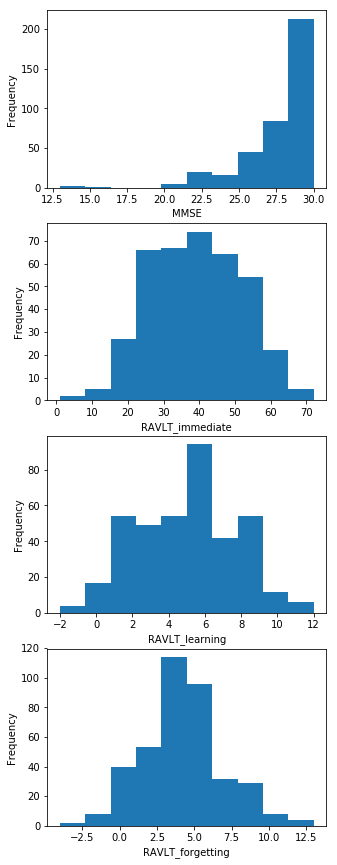

In [26]:
df = df_no_missing_cog

cog_cols1 = df.columns[49411:49415]
fig, ax = plt.subplots(len(cog_cols1), 1, figsize=(5, 15))
for i in range(len(cog_cols1)):
    ax[i].hist(df[cog_cols1[i]])
    ax[i].set_xlabel(cog_cols1[i])
    ax[i].set_ylabel("Frequency")

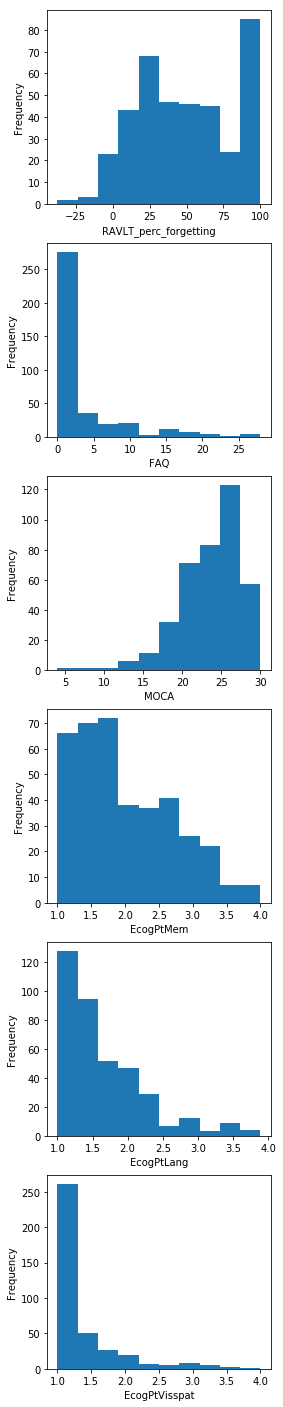

In [27]:
cog_cols2 = df.columns[49415:49421]
fig, ax = plt.subplots(len(cog_cols2), 1, figsize=(4, 25))
for i in range(len(cog_cols2)):
    ax[i].hist(df[cog_cols2[i]])
    ax[i].set_xlabel(cog_cols2[i])
    ax[i].set_ylabel("Frequency")

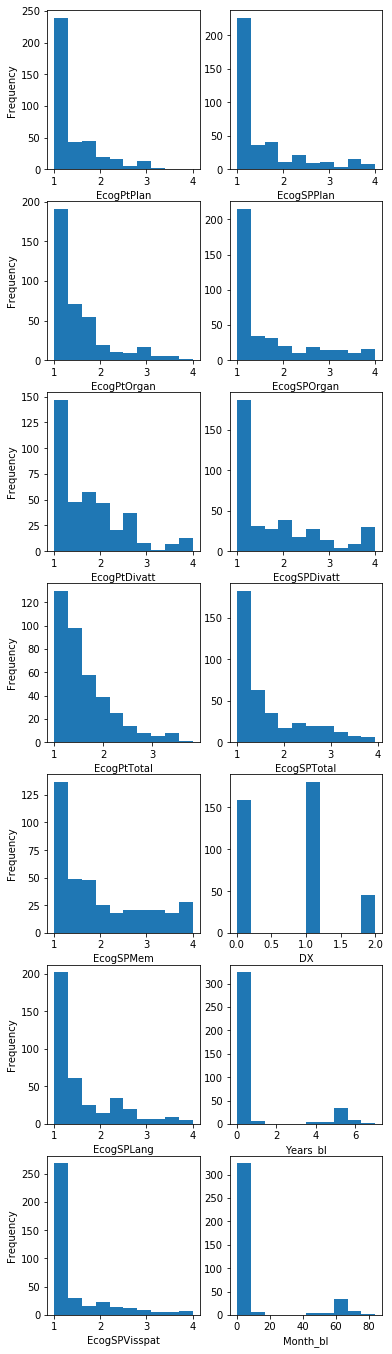

In [28]:
EcogPt_cols = df.columns[49421:49428]
fig, ax = plt.subplots(len(EcogPt_cols), 2, figsize=(6, 24))
for i in range(len(EcogPt_cols)):
    ax[i][0].hist(df[EcogPt_cols[i]])
    ax[i][0].set_xlabel(EcogPt_cols[i])
    ax[i][0].set_ylabel("Frequency")
EcogSP_cols = df.columns[49428:49435]
for i in range(len(EcogSP_cols)):
    ax[i][1].hist(df[EcogSP_cols[i]])
    ax[i][1].set_xlabel(EcogSP_cols[i])

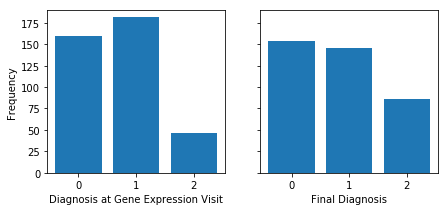

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), sharey=True)
dx_counts = df.groupby(['DX']).size()
ax[0].bar(dx_counts.index, dx_counts.values)
ax[0].set_xlabel('Diagnosis at Gene Expression Visit')
ax[0].set_ylabel("Frequency")
final_dx_counts = df.groupby(['Final_DX']).size()
ax[1].bar(final_dx_counts.index, final_dx_counts.values)
ax[1].set_xlabel('Final Diagnosis')

In [30]:
def plt_bar(col):
    counts = df.groupby([col]).size()
    plt.bar(counts.index, counts.values)
    plt.xlabel(col)
    plt.ylabel('Frequency')

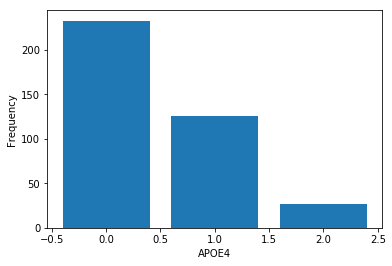

In [31]:
# APOE4 from ADNIMERGE
plt_bar('APOE4')

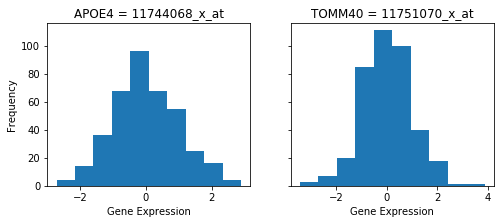

In [32]:
# plot APOE4 and TOMM40 gene expression
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True);
ax[0].hist(df['11744068_x_at']);
ax[0].set_title('APOE4 = 11744068_x_at');
ax[0].set_xlabel('Gene Expression');
ax[0].set_ylabel('Frequency');
ax[1].hist(df['11751070_x_at']);
ax[1].set_title('TOMM40 = 11751070_x_at');
ax[1].set_xlabel('Gene Expression');

In [33]:
df_full = pd.read_csv('DROPPED_GENE_EXPRESSION_UNIQUE.csv', index_col = 0)

In [34]:
cog_cols = df_full.columns[49408:49432]
df_cog = df_full[cog_cols]
df_cog['Final_DX'] = df_full['Final_DX']
df_cog['DX'] = df_full['DX']
df_cog.head()

C:\Users\Jackie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jackie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,...,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,Final_DX,DX
7,0.0,3.0,4.0,30.0,57.0,6.0,9.0,64.28570,1.0,28.0,...,1.58974,1.125,1.00000,1.00000,1.00,1.00000,1.0,1.02564,0,0.0
14,1.5,16.0,24.0,28.0,38.0,2.0,2.0,28.57140,5.0,20.0,...,1.87179,3.250,3.66667,1.28571,2.25,1.83333,3.0,2.62162,2,1.0
22,0.0,7.0,8.0,28.0,55.0,8.0,1.0,7.69231,0.0,21.0,...,1.17949,1.000,1.11111,1.00000,1.00,1.00000,1.0,1.02564,0,0.0
27,1.0,7.0,9.0,30.0,40.0,8.0,5.0,45.45450,0.0,22.0,...,1.33333,1.000,1.00000,1.00000,1.00,1.00000,1.0,1.00000,1,1.0
35,0.0,6.0,11.0,28.0,44.0,10.0,4.0,30.76920,0.0,25.0,...,1.00000,1.250,1.00000,1.00000,1.00,1.00000,1.0,1.05128,0,0.0


In [35]:
df_cog.dtypes

CDRSB                    float64
ADAS11                   float64
ADAS13                   float64
MMSE                     float64
RAVLT_immediate          float64
RAVLT_learning           float64
RAVLT_forgetting         float64
RAVLT_perc_forgetting    float64
FAQ                      float64
MOCA                     float64
EcogPtMem                float64
EcogPtLang               float64
EcogPtVisspat            float64
EcogPtPlan               float64
EcogPtOrgan              float64
EcogPtDivatt             float64
EcogPtTotal              float64
EcogSPMem                float64
EcogSPLang               float64
EcogSPVisspat            float64
EcogSPPlan               float64
EcogSPOrgan              float64
EcogSPDivatt             float64
EcogSPTotal              float64
Final_DX                   int64
DX                       float64
dtype: object

In [36]:
corr_matrix = np.corrcoef(df_cog, rowvar = False)
corr_matrix

array([[ 1.        ,  0.72595596,  0.72448254, -0.72693223, -0.54983633,
        -0.41349527,  0.13531603,  0.50752157,  0.83541761, -0.64208801,
         0.42488113,  0.25054816,  0.31406716,  0.3522995 ,  0.31471124,
         0.23360805,  0.37043629,  0.74627875,  0.67002019,  0.70750669,
         0.72122996,  0.70927219,  0.66226626,  0.77921219,  0.74329702,
         0.79999554],
       [ 0.72595596,  1.        ,  0.97536503, -0.74010809, -0.70484906,
        -0.52239185,  0.17120318,  0.6003241 ,  0.68103294, -0.74203874,
         0.37723257,  0.25088726,  0.30353582,  0.30068744,  0.31413028,
         0.18208519,  0.34370269,  0.64045876,  0.59291142,  0.52111462,
         0.54656956,  0.52576812,  0.51626722,  0.62784305,  0.67691687,
         0.66634175],
       [ 0.72448254,  0.97536503,  1.        , -0.74225321, -0.74210046,
        -0.55829236,  0.21254987,  0.64606462,  0.69906976, -0.76207338,
         0.39980388,  0.24329439,  0.30677058,  0.2976392 ,  0.30716968,
       

In [37]:
print("Cognitive Test Correlations with Final_DX\n")
final_dx_df = pd.DataFrame()
final_dx_df['cog'] = df_cog.columns
final_dx_df['val'] = corr_matrix[24,:]
final_dx_df = final_dx_df.sort_values(['val'])
final_dx_df.head(20)

Cognitive Test Correlations with Final_DX



,cog,val
9,MOCA,-0.610607
3,MMSE,-0.581375
4,RAVLT_immediate,-0.549648
5,RAVLT_learning,-0.375219
6,RAVLT_forgetting,0.226330
15,EcogPtDivatt,0.295476
12,EcogPtVisspat,0.342990
14,EcogPtOrgan,0.348633
11,EcogPtLang,0.367308
13,EcogPtPlan,0.396204


In [38]:
print("Cognitive Test Correlations with DX\n")
dx_df = pd.DataFrame()
dx_df['cog'] = df_cog.columns
dx_df['val'] = corr_matrix[25,:]
dx_df = final_dx_df.sort_values(['val'])
dx_df.head(20)

Cognitive Test Correlations with DX



,cog,val
9,MOCA,-0.610607
3,MMSE,-0.581375
4,RAVLT_immediate,-0.549648
5,RAVLT_learning,-0.375219
6,RAVLT_forgetting,0.226330
15,EcogPtDivatt,0.295476
12,EcogPtVisspat,0.342990
14,EcogPtOrgan,0.348633
11,EcogPtLang,0.367308
13,EcogPtPlan,0.396204


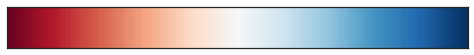

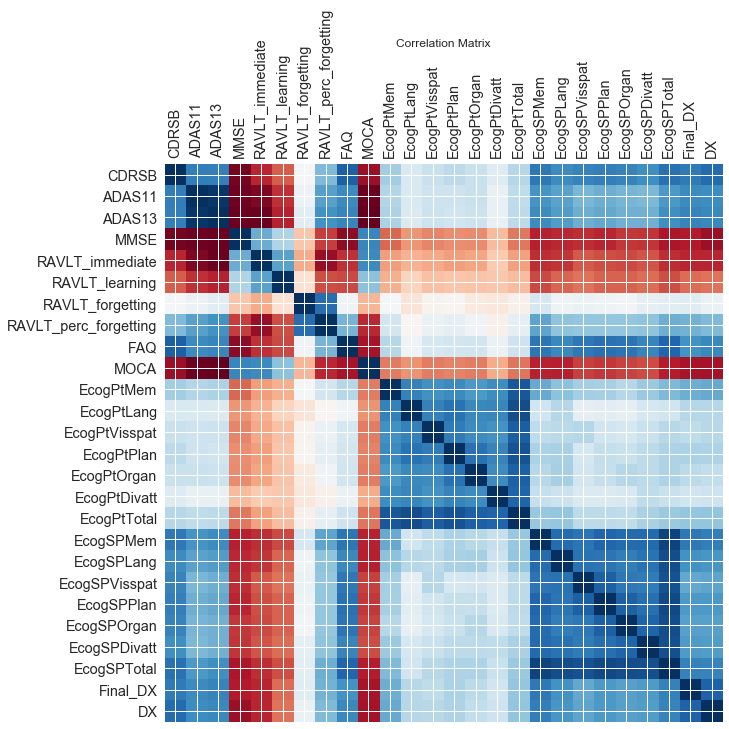

In [41]:
dpal = sns.choose_colorbrewer_palette('diverging', as_cmap=True)
plt.rcParams["figure.figsize"] = [10,10]
plt.matshow(corr_matrix, cmap=dpal)
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=0);
plt.title("Correlation Matrix", y=1.2)
plt.xticks(range(26), df_cog.columns, rotation=90, fontsize = 'large')
plt.yticks(range(26), df_cog.columns, fontsize = 'large');